In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# JAX-related imports
import jax
import jax.numpy as jnp
from jax_core.simulator.vessels.csad_jax import load_csad_parameters, csad_x_dot
from jax_core.utils import rk4_step
from jax_core.simulator.waves.wave_spectra_jax import jonswap_spectrum
from jax_core.simulator.waves.wave_load_jax_jit import init_wave_load, wave_load

# NumPy-related imports
from mclsimpy.simulator import CSAD_DP_6DOF
from mclsimpy.waves import JONSWAP, WaveLoad

In [2]:
# --- Define the JAX simulation function ---
def run_jax_simulation(N=100, dt=0.01, simtime=100.0):
    """
    Runs the JAX-based vessel simulation for given parameters.
    Returns the elapsed simulation time (excluding warmup).
    """
    # Set the configuration file (correct path)
    config_file = "/home/kmroen/miniconda3/envs/tensor/lib/python3.9/site-packages/mclsimpy/vessel_data/CSAD/vessel_json.json"
    
    # Time grid and steps
    t_array = jnp.arange(0, simtime, dt)
    n_steps = t_array.shape[0]
    
    # Load vessel parameters and initial conditions
    params_jit = load_csad_parameters(config_file)
    eta_init = jnp.zeros(6)
    nu_init  = jnp.zeros(6)
    x = jnp.concatenate([eta_init, nu_init])
    
    Uc = 0.0
    beta_c = 0.0
    tau_control = jnp.zeros(6)
    
    # Define wave parameters
    hs = 5.0 / 90.0
    tp = 10.0 * jnp.sqrt(1/90)
    gamma = 3.3
    wp = 2 * jnp.pi / tp
    wmin = 0.5 * wp
    wmax = 3.0 * wp
    wave_freqs = jnp.linspace(wmin, wmax, N)
    
    omega, wave_spectrum = jonswap_spectrum(wave_freqs, hs, tp, gamma=gamma, freq_hz=False)
    dw = (wmax - wmin) / N
    wave_amps = jnp.sqrt(2.0 * wave_spectrum * dw)
    
    key = jax.random.PRNGKey(0)
    rand_phase = jax.random.uniform(key, shape=(N,), minval=0, maxval=2*jnp.pi)
    wave_angles = jnp.ones(N) * (jnp.pi / 4)
    
    wl = init_wave_load(
         wave_amps=wave_amps,
         freqs=wave_freqs,
         eps=rand_phase,
         angles=wave_angles,
         config_file=config_file,
         rho=1025,
         g=9.81,
         dof=6,
         depth=100,
         deep_water=True,
         qtf_method="Newman",
         qtf_interp_angles=True,
         interpolate=True
    )
    
    # Define the simulation step function for lax.scan
    def simulation_step(x, t):
         eta = x[:6]
         tau_wave = wave_load(t, eta, wl)
         tau = tau_control + tau_wave
         x_next = rk4_step(x, dt, csad_x_dot, Uc, beta_c, tau, params_jit)
         return x_next, x_next
    
    # Warm-up run to trigger JIT compilation
    _ = jax.lax.scan(simulation_step, x, t_array)
    
    # Now perform the timed simulation
    start_time = time.perf_counter()
    _, xs = jax.lax.scan(simulation_step, x, t_array)
    elapsed = time.perf_counter() - start_time
    return elapsed


In [3]:
# --- Define the NumPy simulation function ---
def run_numpy_simulation(N=100, dt=0.01, simtime=100):
    """
    Runs the NumPy-based vessel simulation for given parameters.
    Returns the elapsed simulation time.
    """
    t = np.arange(0, simtime, dt)
    
    vessel = CSAD_DP_6DOF(dt=dt, method='RK4')
    Uc = 0.0
    beta_c = 0.0
    tau_control = np.zeros(6, dtype=float)
    
    hs = 5.0 / 90.0
    # Note: The original NumPy code uses 9.0 * sqrt(1/90), here we keep the same pattern.
    tp = 9.0 * np.sqrt(1/90)
    gamma = 3.3
    wp = 2 * np.pi / tp
    wmin = 0.5 * wp
    wmax = 3.0 * wp
    wave_freqs = np.linspace(wmin, wmax, N)
    
    jonswap = JONSWAP(wave_freqs)
    _, wave_spectrum = jonswap(hs=hs, tp=tp, gamma=gamma)
    
    dw = (wmax - wmin) / N
    wave_amps = np.sqrt(2 * wave_spectrum * dw)
    
    np.random.seed(0)
    rand_phase = np.random.uniform(0, 2*np.pi, size=N)
    wave_angles = np.ones(N) * np.pi / 4
    
    waveload = WaveLoad(
         wave_amps=wave_amps,
         freqs=wave_freqs,
         eps=rand_phase,
         angles=wave_angles,
         config_file=vessel._config_file,
         interpolate=True,
         qtf_method="Newman",
         deep_water=True,
    )
    
    eta_init = np.zeros(6)
    nu_init = np.zeros(6)
    vessel.set_eta(eta_init)
    vessel.set_nu(nu_init)
    
    start_time = time.perf_counter()
    for current_time in t:
         tau_wave = waveload(current_time, vessel.get_eta())
         tau = tau_control + tau_wave
         vessel.integrate(Uc, beta_c, tau)
    elapsed = time.perf_counter() - start_time
    return elapsed

In [4]:
# Define the parameter arrays:
# Sampling frequencies and corresponding dt values (in seconds)
freqs = [10, 20, 40, 80, 160, 320]    # in Hz
dts = [1/f for f in freqs]
# The number of wave components is set to the same values as the frequencies.
Ns = freqs[:]  
# Total simulation times for each test case
simtimes = [15, 30, 60, 120, 240, 480]

results = []
for N, dt, simtime in zip(Ns, dts, simtimes):
    print(f"\nRunning simulation for N={N}, dt=1/{int(1/dt)}s ({dt:.5f}s), simtime={simtime}s")
    
    # Run JAX simulation timing
    jax_time = run_jax_simulation(N=N, dt=dt, simtime=simtime)
    # Run NumPy simulation timing
    numpy_time = run_numpy_simulation(N=N, dt=dt, simtime=simtime)
    
    speedup = numpy_time / jax_time if jax_time > 0 else np.nan
    results.append({
        "N": N,
        "dt (s)": dt,
        "simtime (s)": simtime,
        "JAX_time (s)": jax_time,
        "NumPy_time (s)": numpy_time,
        "Speedup (NumPy/JAX)": speedup
    })
    print(f"JAX: {jax_time:.4f} s, NumPy: {numpy_time:.4f} s, Speedup: {speedup:.2f}")


Running simulation for N=10, dt=1/10s (0.10000s), simtime=15s
***************************************Generate QTF matrices****************************************
Using Newman

***************************************QTF matrices complete.***************************************
***************************************Generate QTF matrices****************************************
Using Newman

***************************************QTF matrices complete.***************************************
JAX: 0.0488 s, NumPy: 0.1304 s, Speedup: 2.67

Running simulation for N=20, dt=1/20s (0.05000s), simtime=30s
***************************************Generate QTF matrices****************************************
Using Newman

***************************************QTF matrices complete.***************************************
***************************************Generate QTF matrices****************************************
Using Newman

***************************************QTF matrices complete.****

In [5]:
# Convert the results into a DataFrame
results_df = pd.DataFrame(results)
print("\nBenchmark Results:")
print(results_df)


Benchmark Results:
     N    dt (s)  simtime (s)  JAX_time (s)  NumPy_time (s)  \
0   10  0.100000           15      0.048788        0.130373   
1   20  0.050000           30      0.163613        0.585657   
2   40  0.025000           60      0.246685        2.349608   
3   80  0.012500          120      0.948713       46.329141   
4  160  0.006250          240      4.008973      286.618910   
5  320  0.003125          480     42.667779     2598.332662   

   Speedup (NumPy/JAX)  
0             2.672233  
1             3.579532  
2             9.524720  
3            48.833695  
4            71.494341  
5            60.896835  


Using style: ggplot


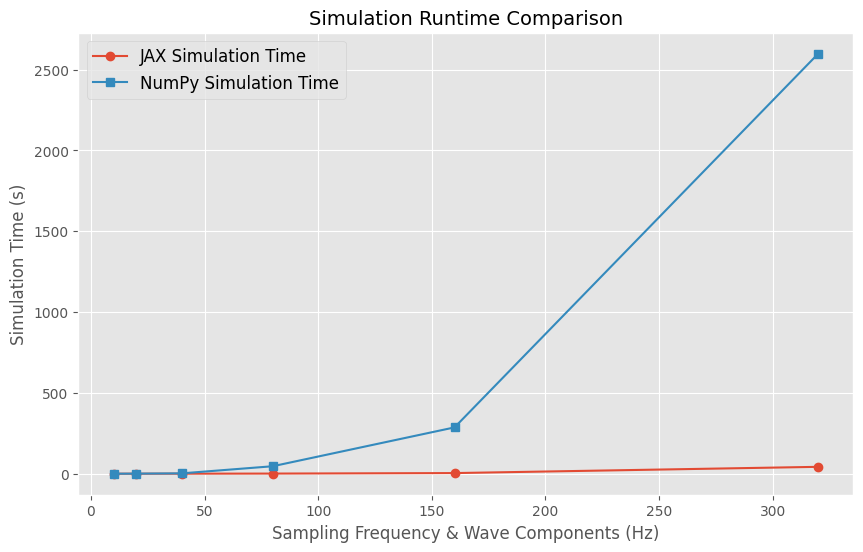

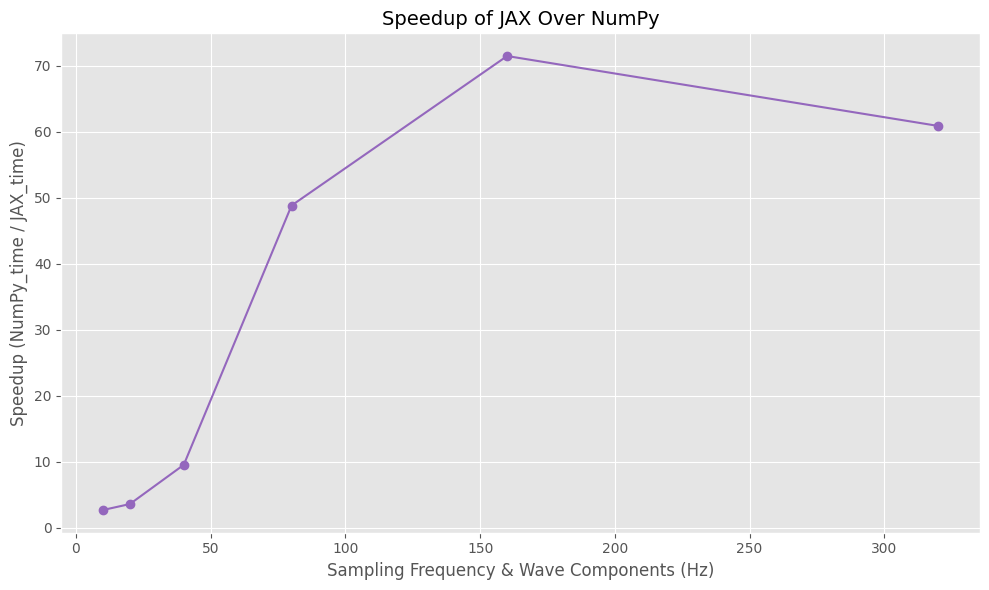

In [6]:
# --- Visualization ---
# Select a style from a list of candidates based on what's available
candidate_styles = ['seaborn-whitegrid', 'seaborn', 'ggplot', 'classic', 'default']
style_to_use = next((s for s in candidate_styles if s in plt.style.available), 'default')
plt.style.use(style_to_use)
print(f"Using style: {style_to_use}")

# Plot raw simulation times for both JAX and NumPy as a function of frequency (Hz)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(results_df["N"], results_df["JAX_time (s)"], marker='o', label='JAX Simulation Time')
ax.plot(results_df["N"], results_df["NumPy_time (s)"], marker='s', label='NumPy Simulation Time')
ax.set_xlabel("Sampling Frequency & Wave Components (Hz)", fontsize=12)
ax.set_ylabel("Simulation Time (s)", fontsize=12)
ax.set_title("Simulation Runtime Comparison", fontsize=14)
ax.legend(fontsize=12)
ax.grid(True)

# Plot speedup (NumPy_time / JAX_time) vs. Sampling Frequency/Wave Components
fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.plot(results_df["N"], results_df["Speedup (NumPy/JAX)"], marker='o', color='tab:purple')
ax2.set_xlabel("Sampling Frequency & Wave Components (Hz)", fontsize=12)
ax2.set_ylabel("Speedup (NumPy_time / JAX_time)", fontsize=12)
ax2.set_title("Speedup of JAX Over NumPy", fontsize=14)
ax2.grid(True)

plt.tight_layout()
plt.show()